In [ ]:
# ML-1 Временные ряды
# Преподаватель: Алексей Кузьмин
#
# Скачайте материалы к ДЗ из личного кабинета. ПРоанализируйте ряды, сделайте их стационарными.
# Решением будет ссылка на гитхаб с ноутбуком.




In [262]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from scipy.stats import boxcox

import time

%matplotlib inline

In [61]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(14, 12), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return    

In [159]:
registration= pd.read_csv("monthly-us-auto-registration-tho.csv", sep=";")
dowjones = pd.read_csv("weekly-closings-of-the-dowjones-.csv")

## Разбор ряда   monthly_us_auto_registration_tho

In [63]:
registration.head()


,Month,registration
0,1947-01,209
1,1947-02,214
2,1947-03,265
3,1947-04,290
4,1947-05,287


In [64]:
# получим порядковое значения месяца от начала ряда
first_year = (time.strptime(registration.iloc[0]['Month'], "%Y-%m").tm_year)

In [79]:
registration['time'] = registration.apply(lambda x: (time.strptime(x['Month'], "%Y-%m").tm_year-first_year)*12 + time.strptime(x['Month'], "%Y-%m").tm_mon -1, axis=1)

time_lags = registration['time']
registration_raw = registration['registration']


registration.head()

,Month,registration,time
0,1947-01,209,0
1,1947-02,214,1
2,1947-03,265,2
3,1947-04,290,3
4,1947-05,287,4


Проанализируем исходный ряд

Results of Dickey-Fuller Test:
Test Statistic                  -1.225039
p-value                          0.662733
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


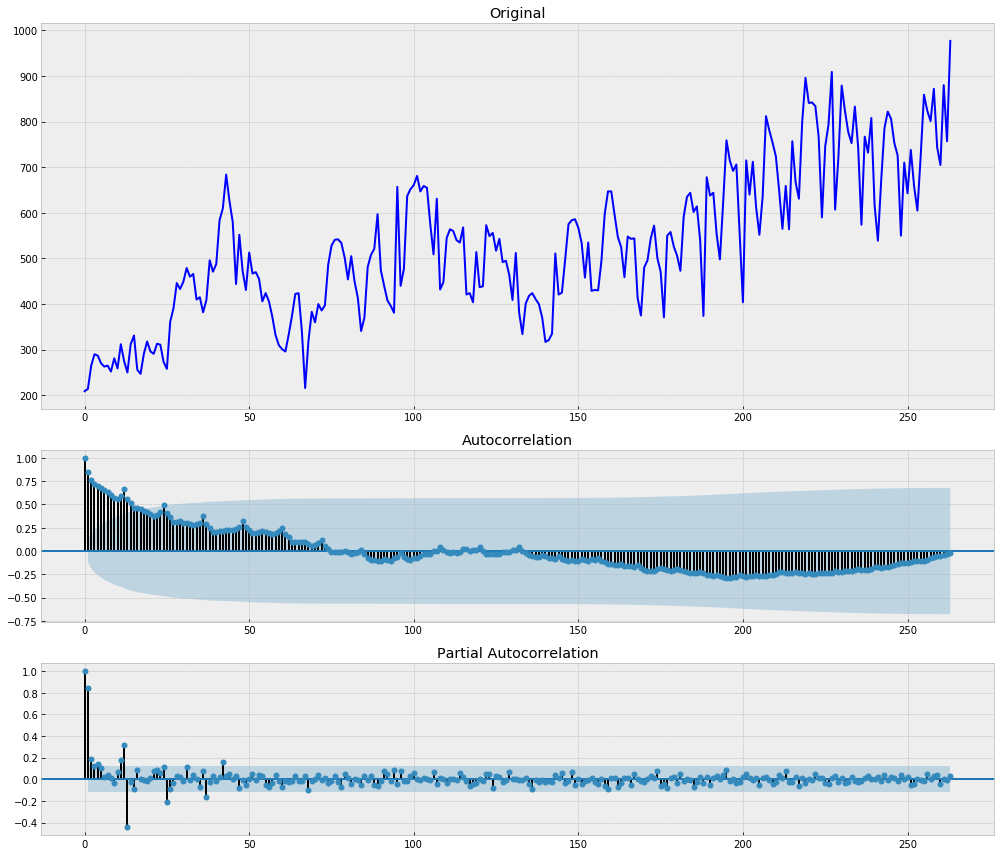

In [66]:
tsplot(registration_raw, lags=time_lags)

Тест Дики-Фуллера и графики коррелограмм не отвергают гипотезу о нестационарности ряда.

При взгляде на графики можно видеть некоторую разницу в размахе дисперсии в начале и конце временного ряда. 
    
       
По этому первым действием используем преобразование Бокса-Кокса.
       

### С использованием преобразованием Бокса-Кокса

In [117]:
registration_bc = boxcox(registration_raw, 0)

Results of Dickey-Fuller Test:
Test Statistic                  -1.941628
p-value                          0.312738
#Lags Used                      14.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


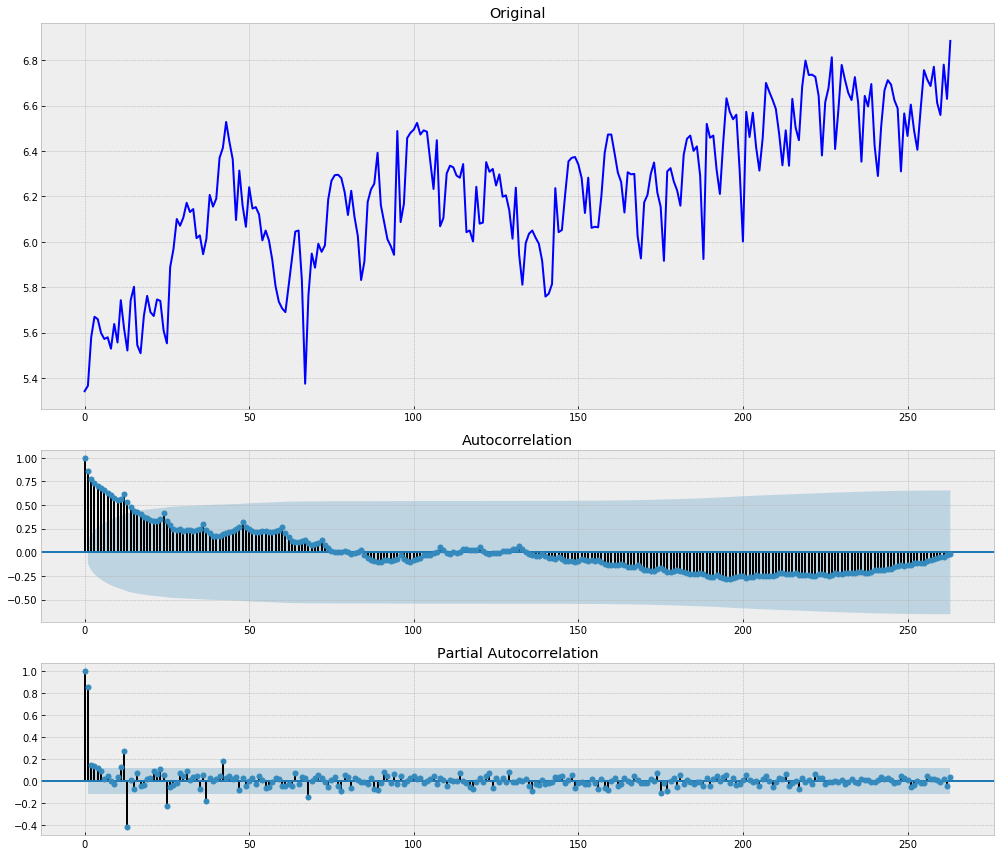

In [118]:
tsplot(registration_bc, lags=time_lags)

Как видно преобразование не достаточно сравняло размах дисперсии и тест Дикки-Фуллера все еще не отвергает гипотезу о нестационарности ряда. По графику ряда видно наличие тренда. Уберем его дифференцированием.

In [119]:
registration_bc_d = registration_bc[1:] - registration_bc[:-1]


Results of Dickey-Fuller Test:
Test Statistic                  -4.362471
p-value                          0.000346
#Lags Used                      14.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


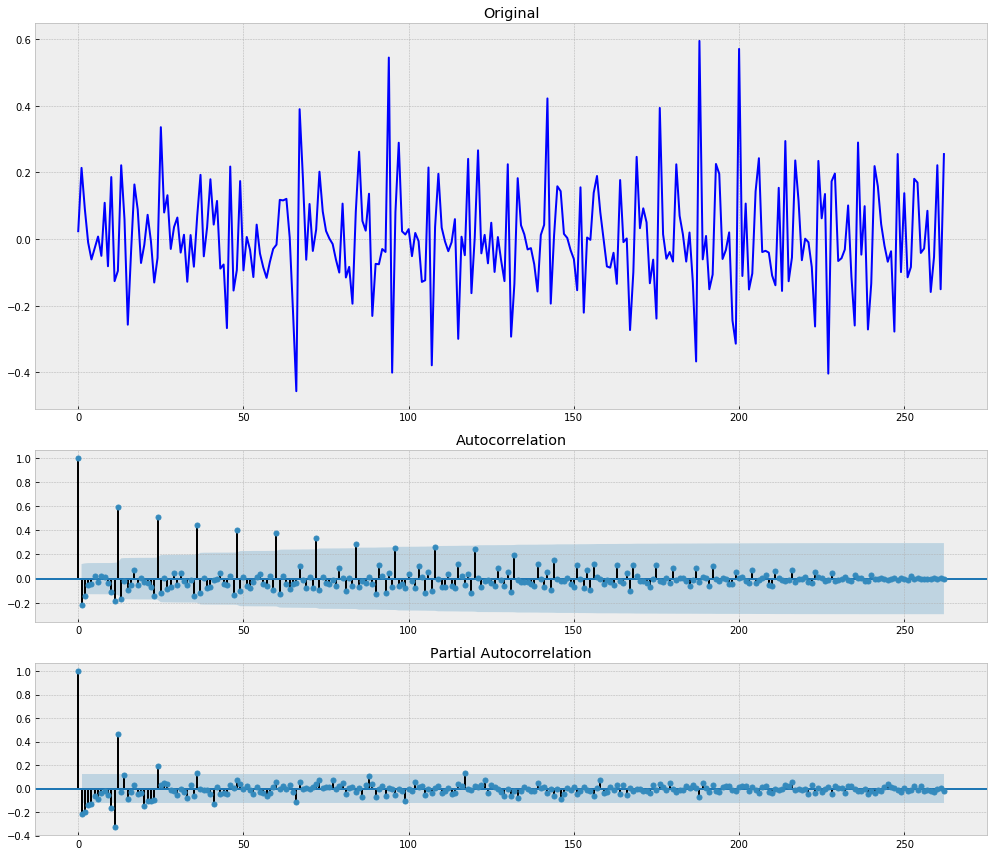

In [120]:
tsplot(registration_bc_d, lags=time_lags[:-1])

Как видно диференцирование позволило убрать тренд и тест Дикки-Фуллера позволяет отвергнуть гипотиезу о нестационарности ряда, однако по графику коррелограммы видно сильное влияние сезонности. Необходимое ее убрать.

In [121]:
registration_bc_d_s = registration_bc_d[12:] - registration_bc_d[:-12]

Results of Dickey-Fuller Test:
Test Statistic                -6.528275e+00
p-value                        1.001817e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


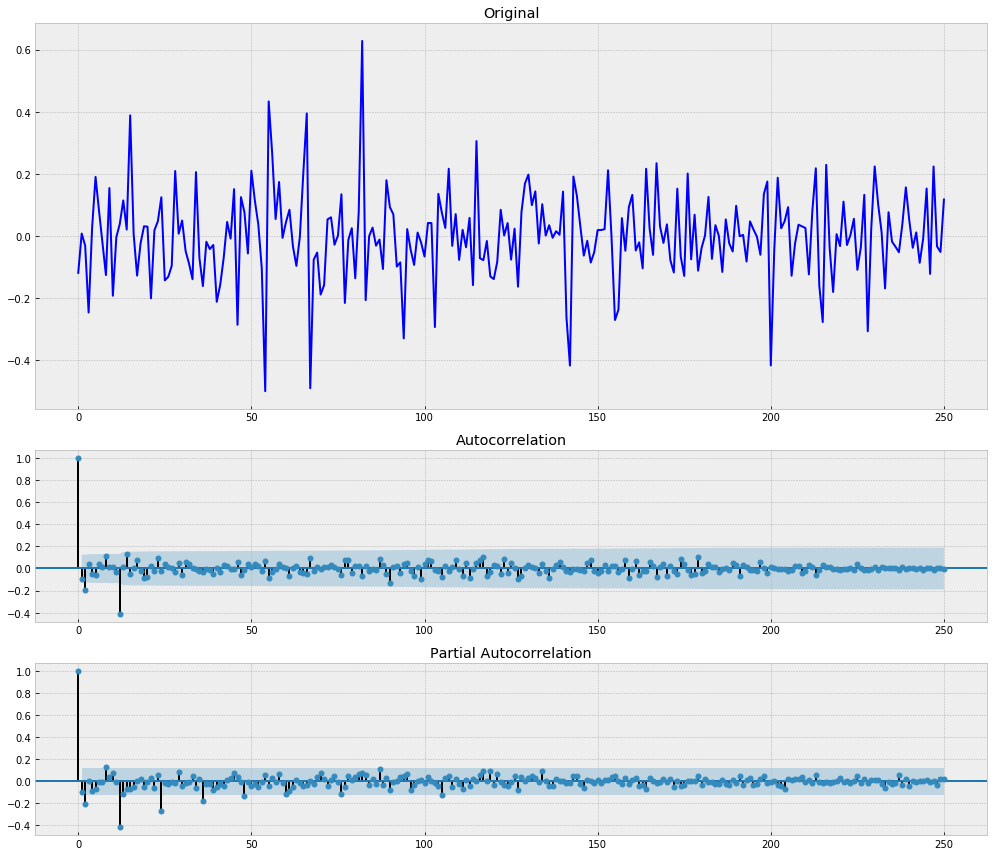

In [123]:
tsplot(registration_bc_d_s, lags=time_lags[:-13])

Теперь тест Дики-Фуллера и графики коррелограмм позволяют отвергнуть гипотезу о нестационарности ряда.

С учетом того, что преобразование Бокса-Кокса не позволило убрать разницу в размехе Диспесии, 
можно попробовать привести ряд к стационарному без использования преобразования. 

### Без использования преобразования Бокса-Кокса

In [ ]:
Для уборки тренда используем дифферицирование. 

In [154]:
registration_d = registration_raw[1:] - registration_raw[:-1]

registration_d = np.diff(registration_raw, 1)


Results of Dickey-Fuller Test:
Test Statistic                  -4.176442
p-value                          0.000722
#Lags Used                      14.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


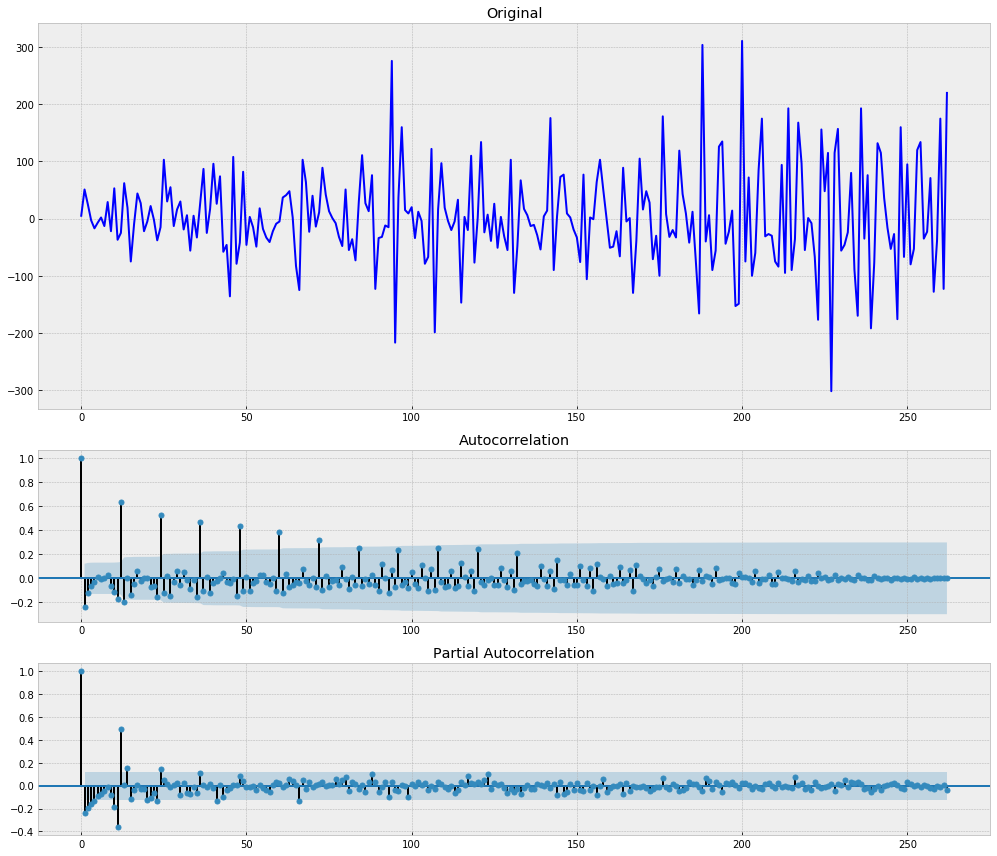

In [155]:
tsplot(registration_d)

Диференцирование позволило убрать тренд и тест Дикки-Фуллера позволяет отвергнуть гипотиезу о нестационарности ряда, однако по графику коррелограммы также видно наличие сильной сезонности. Уберем её.

In [151]:
registration_d_s = registration_d[12:] - registration_d[:-12]

Results of Dickey-Fuller Test:
Test Statistic                -6.531039e+00
p-value                        9.868596e-09
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


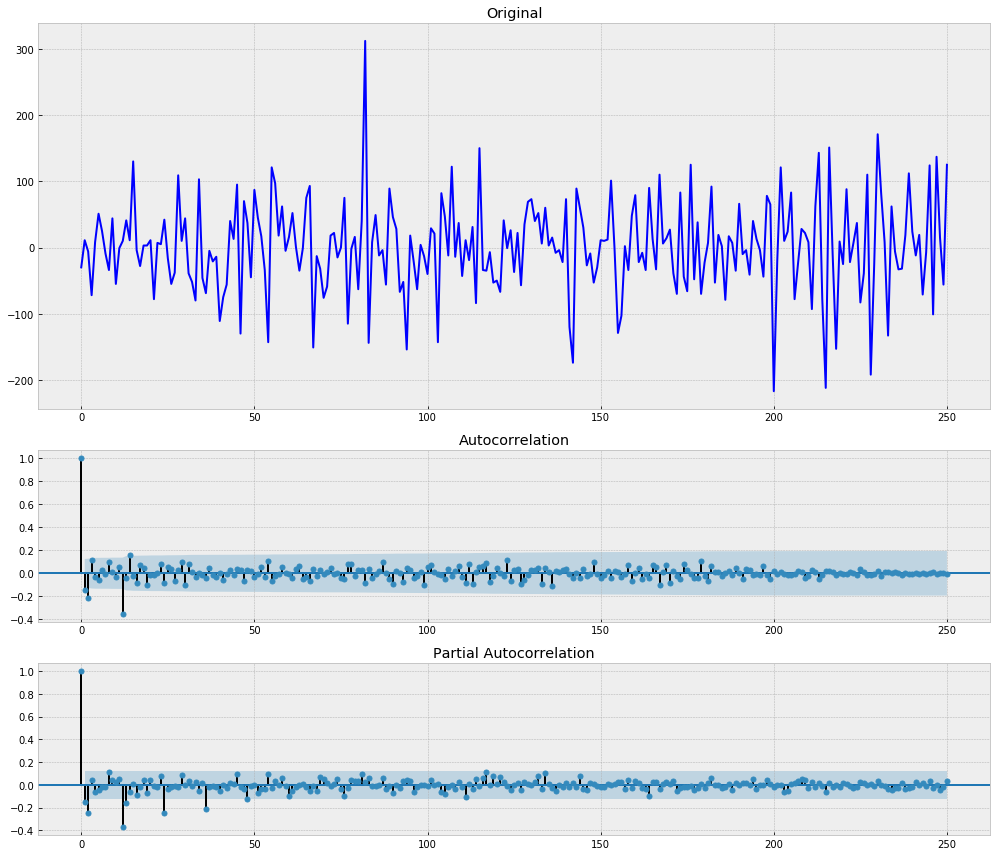

In [153]:
tsplot(registration_d_s)

Теперь тест Дики-Фуллера и графики коррелограмм также позволяют отвергнуть гипотезу о нестационарности ряда.





## Разбор ряда weekly-closings-of-the-dowjones

In [244]:
dowjones.head()

,Week,DowJones
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43


Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


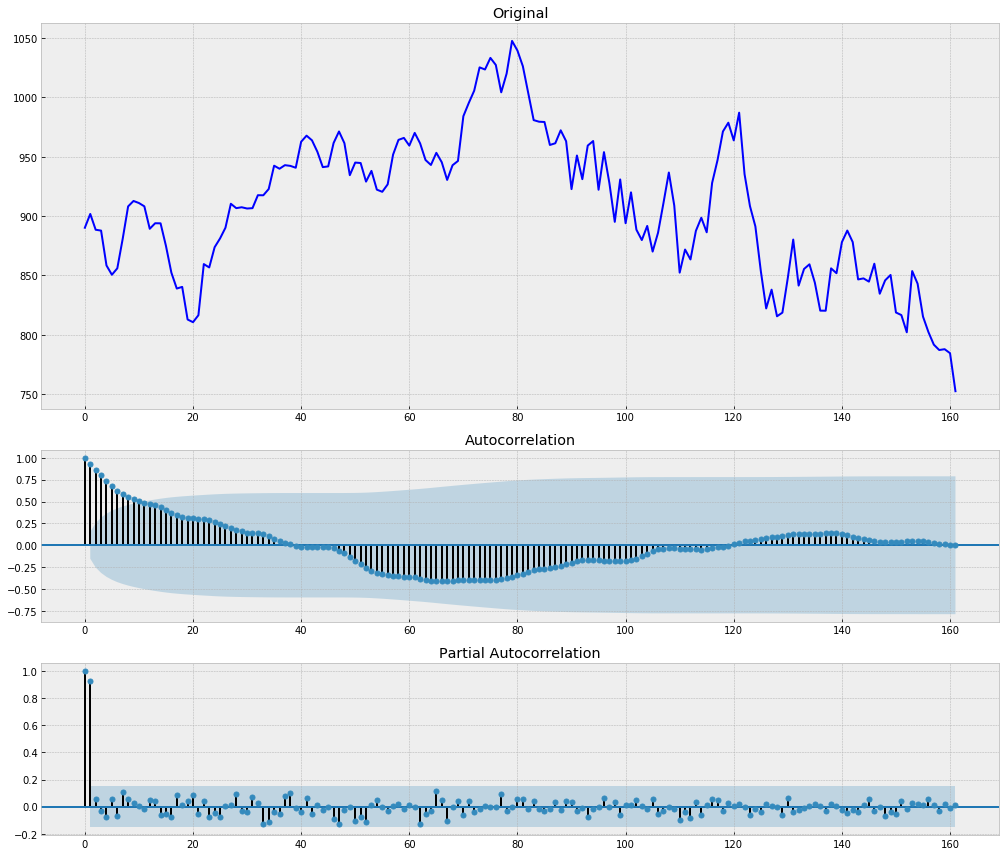

In [245]:
dowjones_raw = dowjones['DowJones']

tsplot(dowjones_raw)

Тест Дики-Фуллера, графики и коррелограммы не позволяет отвергнуть гипотезу о нестационарности ряда, 

На графике имеется тренд, причем тренд меняется примерно на середине ряда. Изменение тренда говорит, что ряд изменил свое поведение и необходимо анализировать части ряда отдельно. 

In [246]:
# Разделим ряд на 2 части

dowjones_raw_1 = dowjones_raw[:80]
dowjones_raw_2 = dowjones_raw[80:]


Рассмотрим первую часть ряда.

Results of Dickey-Fuller Test:
Test Statistic                 -0.566289
p-value                         0.878419
#Lags Used                      1.000000
Number of Observations Used    78.000000
Critical Value (1%)            -3.517114
Critical Value (5%)            -2.899375
Critical Value (10%)           -2.586955
dtype: float64


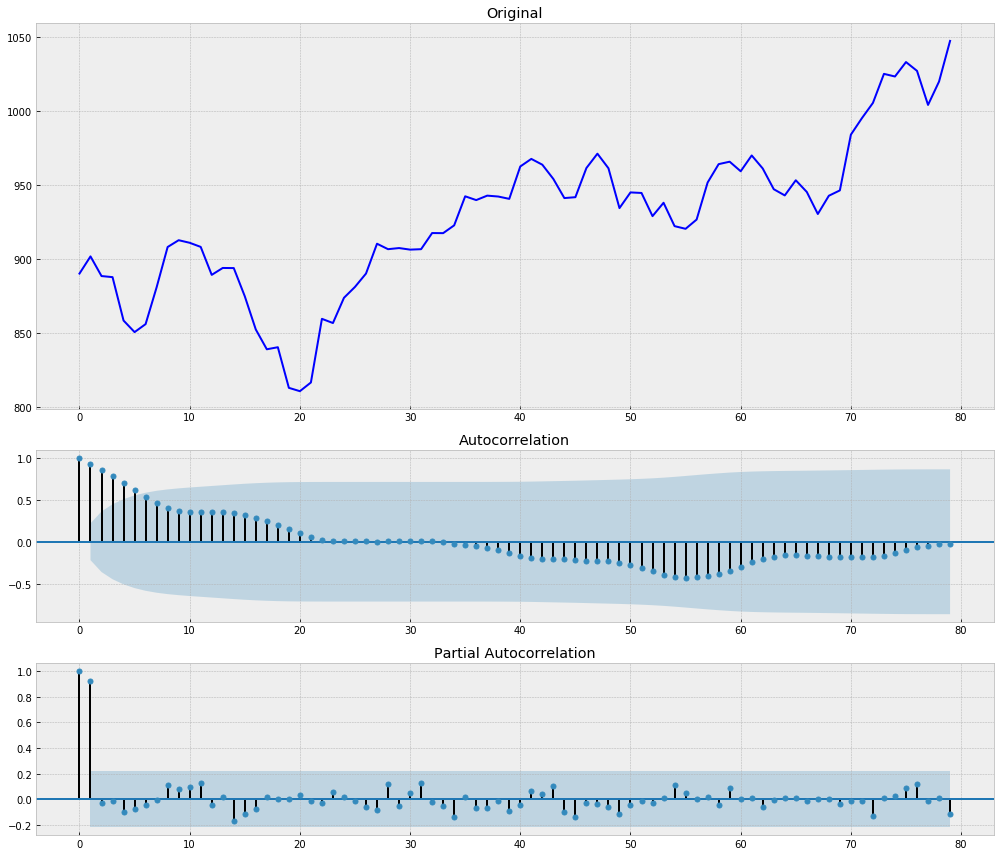

In [253]:
tsplot(dowjones_raw_1)

Так как на графике не видна оразница между размахом дисперсии, то использовать преобразование Бокса-Кокса не будем.
Используем дифференцирование дял уборкеи тренда.

In [254]:
dowjones_d_1 = np.diff(dowjones_raw_1, 1)

Results of Dickey-Fuller Test:
Test Statistic                -6.926592e+00
p-value                        1.111270e-09
#Lags Used                     0.000000e+00
Number of Observations Used    7.800000e+01
Critical Value (1%)           -3.517114e+00
Critical Value (5%)           -2.899375e+00
Critical Value (10%)          -2.586955e+00
dtype: float64


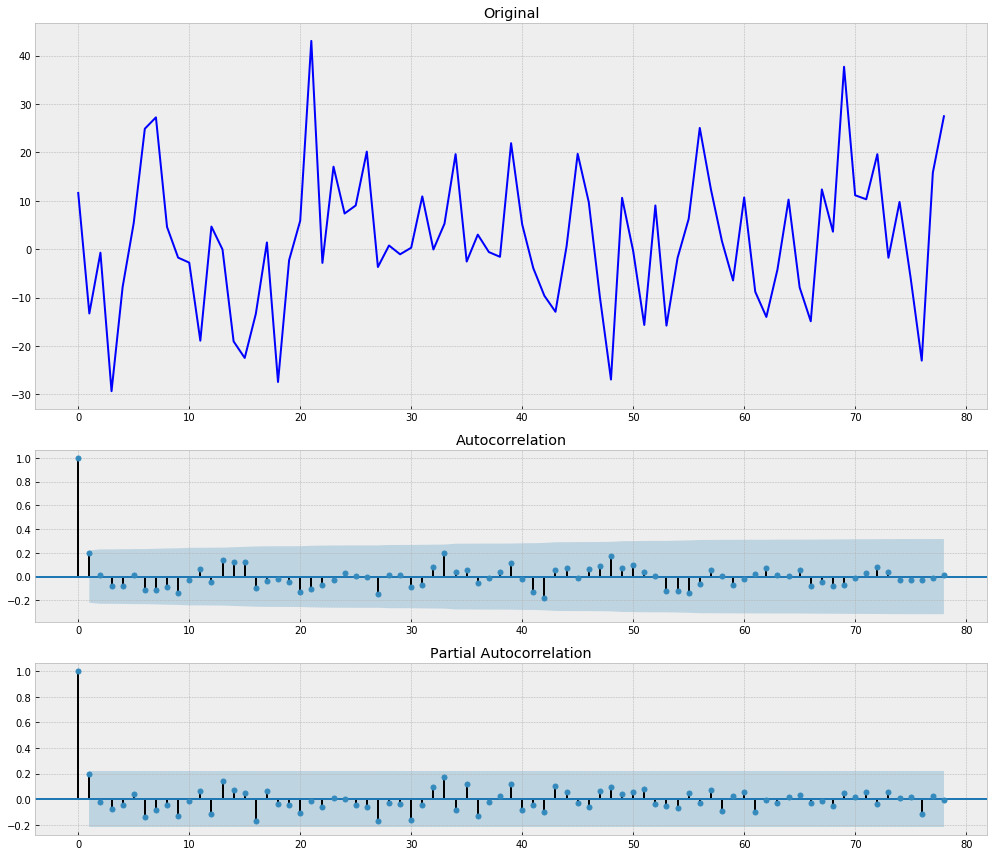

In [255]:
tsplot(dowjones_d_1)

Теперь тест Дики-Фуллера и графики коррелограмм также позволяют отвергнуть гипотезу о нестационарности ряда.



Проанализируем вторую половину ряда, так как первыая не актуальна.

Results of Dickey-Fuller Test:
Test Statistic                 -1.954633
p-value                         0.306812
#Lags Used                      0.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


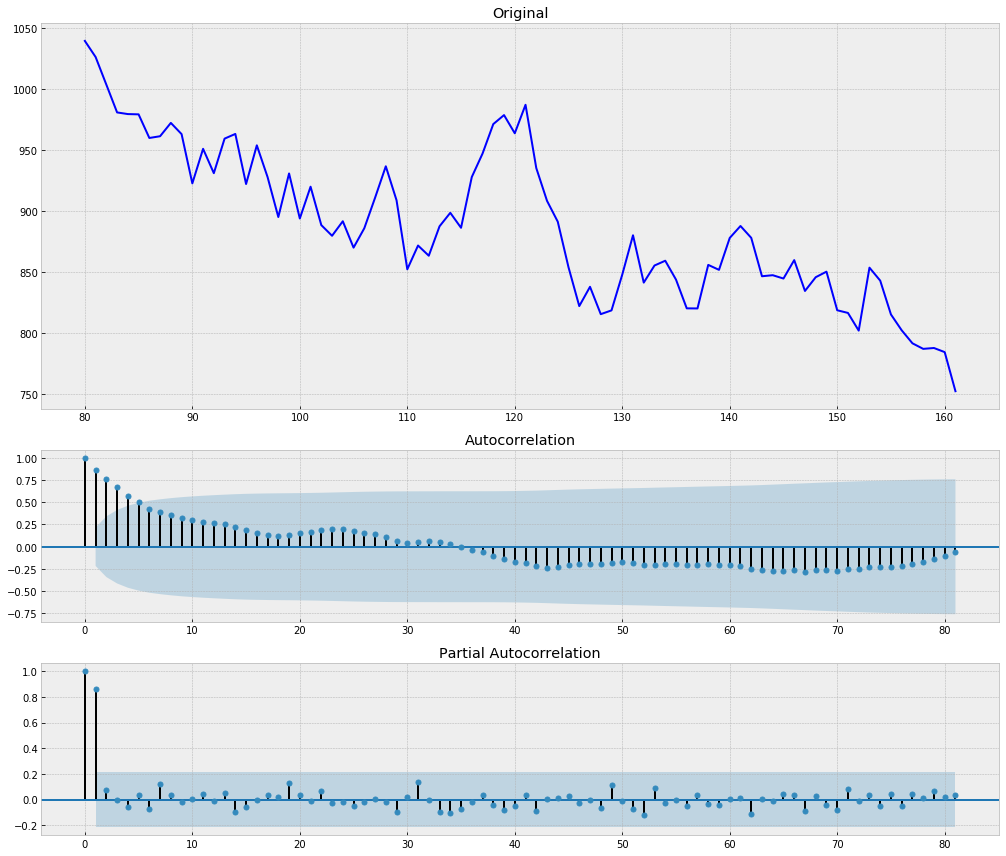

In [256]:
tsplot(dowjones_raw_2)

Как видно и результатов теста и графиков коррелограмм гипотезу о нестационарности ряда отбросить нельзя

Для преобразования ряда к стационарному виду используем преобразование Бокса Кокса, 
а для уборки тренда используем дифференцирование 


In [257]:
dowjones_raw_2_bc = boxcox(dowjones_raw_2, -0.5)

Results of Dickey-Fuller Test:
Test Statistic                 -1.646420
p-value                         0.458908
#Lags Used                      0.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


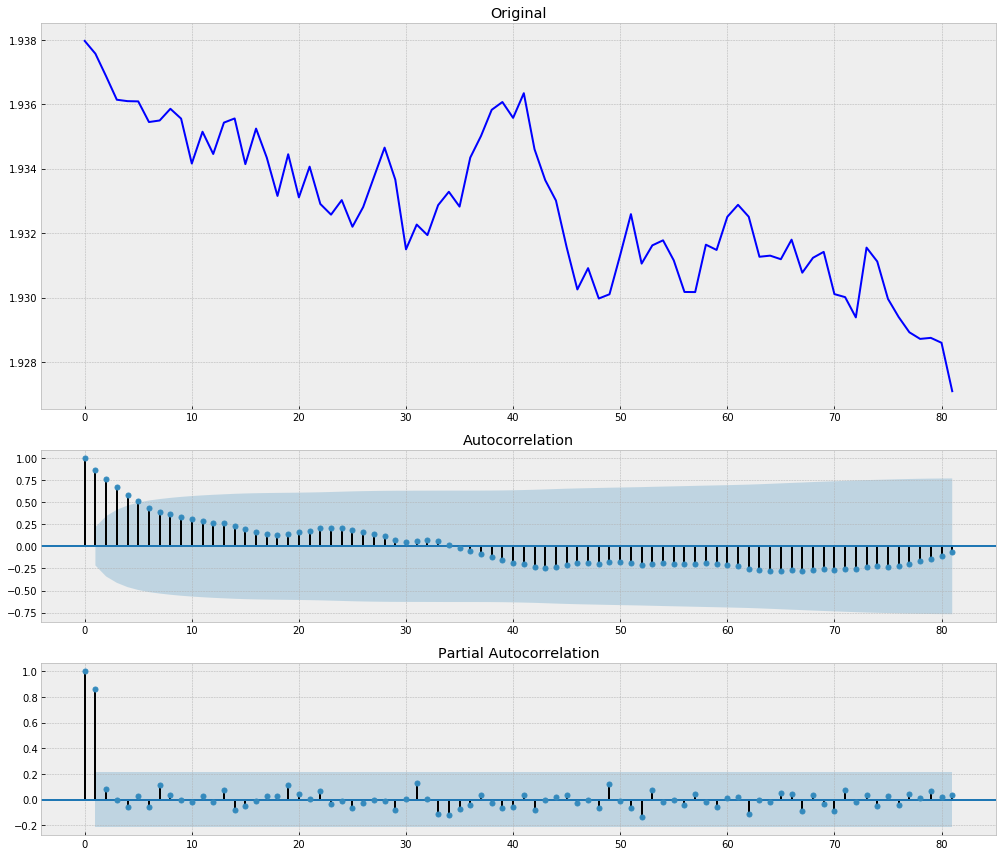

In [258]:
tsplot(dowjones_raw_2_bc)

С помощью дифференцирования уберем тренд.  

In [259]:
dowjones_raw_2_bc_d = dowjones_raw_2_bc[1:] -  dowjones_raw_2_bc[:-1]

Results of Dickey-Fuller Test:
Test Statistic                -1.008471e+01
p-value                        1.163577e-17
#Lags Used                     0.000000e+00
Number of Observations Used    8.000000e+01
Critical Value (1%)           -3.514869e+00
Critical Value (5%)           -2.898409e+00
Critical Value (10%)          -2.586439e+00
dtype: float64


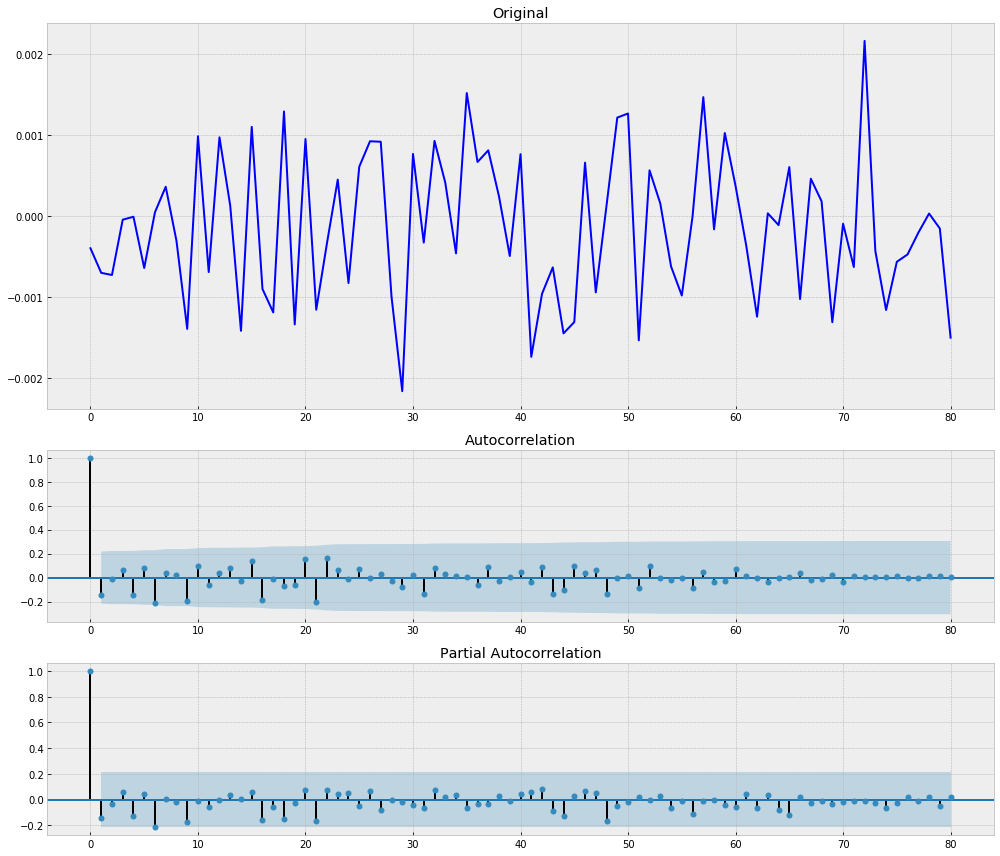

In [260]:
tsplot(dowjones_raw_2_bc_d)

Как видно из теста Дики-Фуллера и графиков коррелограмм позволяют отвергнуть гипотезу о нестационарности ряда.